In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# IMPORT PACKAGES

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as feature
import cmocean.cm
import pandas as pd
import xarray as xr
from scipy import signal
import collections
from windspharm.xarray import VectorWind
# fix to cartopy issue right now
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

In [3]:
# ADDITIONAL FUNCTIONS

# CODE TO SHIFT CCSM DATA BY 1 MONTH (given weird NCAR conventions that calendar date is end of time bound for each month)

def shift_dates_1M(dat):
    y_first = str(dat.time.values[0].year).zfill(4)
    y_last = str(dat.time.values[-2].year).zfill(4)

    time2 = xr.cftime_range(start=str(y_first)+'-01-01', end=str(y_last)+'-12-01', freq="1MS", calendar="noleap")
    dat = dat.assign_coords(time=time2)
    return dat

In [4]:
# PATHS TO DATA FILES

#direc = '/tigress/GEOCLIM/janewb/MODEL_OUT'
direc = '/tigress/janewb/public_html/HITOPO/'
files = collections.defaultdict(dict)

florruns = ['ctrl','hitopo','cam']
cesmruns = ['cesm_ctrl','cesm_cam']
diags = ['u', 'v']

# files['ctrl']['u'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart/TIMESERIES/tau_x.00010101-03000101.ocean.nc'
# files['cam']['u'] = '/tigress/janewb/MODEL_OUT_HERE/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1_CAM/TIMESERIES/tau_x.00010101-02050101.ocean.nc'
# files['hitopo']['u'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1/TIMESERIES/tau_x.00010101-06000101.ocean.nc'
# files['obs']['u'] = '/tigress/janewb/OBS/MERRA2/MERRA2.tauxy.nc'
# files['cesm_ctrl']['u'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_data/b40.1850.track1.1deg.006.pop.h.TAUXregrid.120001-130012.nc'
# files['cesm_cam']['u'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_data/ccsm4pi_topo2.cam2.h0.TAUX.000101-029912.nc'

files['ctrl']['u'] = direc+'flor.ctrl.taux.nc'
files['cam']['u'] = direc+'flor.cam.taux.nc'
files['hitopo']['u'] = direc+'flor.hitopo.taux.nc'
files['obs']['u'] = direc+'obs.merra2.taux-tauy.nc'
files['cesm_ctrl']['u'] = direc+'ccsm4.ctrl.taux.nc'
files['cesm_cam']['u'] = direc+'ccsm4.ideal_cam.taux.nc'

# files['ctrl']['v'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart/TIMESERIES/tau_y.00010101-03000101.ocean.nc'
# files['cam']['v'] = '/tigress/janewb/MODEL_OUT_HERE/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1_CAM/TIMESERIES/tau_y.00010101-02050101.ocean.nc'
# files['hitopo']['v'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1/TIMESERIES/tau_y.00010101-06000101.ocean.nc'
# files['obs']['v'] = '/tigress/janewb/OBS/MERRA2/MERRA2.tauxy.nc'
# files['cesm_ctrl']['v'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_data/b40.1850.track1.1deg.006.pop.h.TAUYregrid.120001-130012.nc'
# files['cesm_cam']['v'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_data/ccsm4pi_topo2.cam2.h0.TAUY.000101-029912.nc'

files['ctrl']['v'] = direc+'flor.ctrl.tauy.nc'
files['cam']['v'] = direc+'flor.cam.tauy.nc'
files['hitopo']['v'] = direc+'flor.hitopo.tauy.nc'
files['obs']['v'] = direc+'obs.merra2.taux-tauy.nc'
files['cesm_ctrl']['v'] = direc+'ccsm4.ctrl.tauy.nc'
files['cesm_cam']['v'] = direc+'ccsm4.ideal_cam.tauy.nc'

In [13]:
# DATA CLEANING

dat0 = collections.defaultdict(dict)
dat = collections.defaultdict(dict)
tsel = collections.defaultdict(dict)

x = 'lon'
y = 'lat'
model_tmin = '0031'
model_tmax = '0200'
obs_tmin = '1980'
obs_tmax = '2019'

# FLOR Runs N/m^2
for run in florruns:
    for diag in diags:
        dat0[run][diag] = xr.open_dataset(files[run][diag])
        dat0[run][diag] = dat0[run][diag].rename({'xu_ocean': 'lon','yu_ocean': 'lat'})
        tsel[run][diag] = dat0[run][diag].sel(time = slice(model_tmin,model_tmax))
        
# CESM Runs
for run in ['cesm_cam']:
    for diag in diags:
        dat0[run][diag] = xr.open_dataset(files[run][diag])
        dat0[run][diag] = shift_dates_1M(dat0[run][diag])
        if diag=='u':
            tsel[run][diag] = dat0[run][diag].rename({'TAUX': 'tau_x'})
            tsel[run][diag] = -tsel[run][diag].tau_x
        if diag=='v':
            tsel[run][diag] = dat0[run][diag].rename({'TAUY': 'tau_y'})
            tsel[run][diag] = -tsel[run][diag].tau_y
for run in ['cesm_ctrl']:
    for diag in diags:
        dat0[run][diag] = xr.open_dataset(files[run][diag])
        dat0[run][diag] = shift_dates_1M(dat0[run][diag])
        if diag=='u':
            tsel[run][diag] = dat0[run][diag].rename({'TAUX_regrid': 'tau_x'})
            tsel[run][diag] = tsel[run][diag].tau_x/10
        if diag=='v':
            tsel[run][diag] = dat0[run][diag].rename({'TAUY_regrid': 'tau_y'})
            tsel[run][diag] = tsel[run][diag].tau_y/10
        
# OBSERVED data N/m^2
for diag in diags:
    dat0['obs'][diag] = xr.open_dataset(files['obs'][diag])
    tsel['obs'][diag] = dat0['obs'][diag].sel(time = slice(obs_tmin,obs_tmax)).rename({'TAUXWTR': 'tau_x','TAUYWTR': 'tau_y'})
    

In [14]:
# Calculate time mean wind stres x and y and save out
taux_tmean = {}
tauy_tmean = {}
vectorwind = {}
curl = {}

for run in ['cesm_cam','cesm_ctrl']: #'ctrl','hitopo', 'cam','obs',
    taux_tmean[run] = tsel[run]['u'].mean(dim='time')
    tauy_tmean[run] = tsel[run]['v'].mean(dim='time')
    # ALTERNATIVE WAY OF CALCULATING CURL THAT DOESN'T WORK FOR ICOADS DATA WHICH HAS MISSING VALUES
    #vectorwind[run] = VectorWind(taux_tmean[run],tauy_tmean[run])
    #curl[run] = vectorwind[run].vorticity()
    
taux_tmean['ctrl'].to_netcdf('WINDSTRESS/taux_ctrl.nc')
taux_tmean['hitopo'].to_netcdf('WINDSTRESS/taux_hitopo.nc')
taux_tmean['cam'].to_netcdf('WINDSTRESS/taux_cam.nc')
taux_tmean['obs'].to_netcdf('WINDSTRESS/taux_merra2.nc')
taux_tmean['cesm_cam'].to_netcdf('WINDSTRESS/taux_cesm_cam.nc')
taux_tmean['cesm_ctrl'].to_netcdf('WINDSTRESS/taux_cesm_ctrl.nc')

tauy_tmean['ctrl'].to_netcdf('WINDSTRESS/tauy_ctrl.nc')
tauy_tmean['hitopo'].to_netcdf('WINDSTRESS/tauy_hitopo.nc')
tauy_tmean['cam'].to_netcdf('WINDSTRESS/tauy_cam.nc')
tauy_tmean['obs'].to_netcdf('WINDSTRESS/tauy_merra2.nc')
tauy_tmean['cesm_cam'].to_netcdf('WINDSTRESS/tauy_cesm_cam.nc')
tauy_tmean['cesm_ctrl'].to_netcdf('WINDSTRESS/tauy_cesm_ctrl.nc')

# NOW CALCULATE CURL USING PYFERRET BACK IN TERMINAL.
# cd /tigress/janewb/HiTopo/WINDSTRESS/
# module load pyferret
# pyferret
# --> go curl.nc icoads
# --> go curl.nc ctrl
# --> go curl.nc hitopo
# --> go curl.n cam
# --> go curl.nc cesm_ctrl
# --> go curl.nc cesm_cam


/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [20]:
# LOAD CURL DATA CALCULATED FROM PYFERRET

curl = {}
curl['obs'] = xr.open_dataset('WINDSTRESS/curl_merra2.nc').CURL
curl['ctrl'] = xr.open_dataset('WINDSTRESS/curl_ctrl.nc').CURL
curl['hitopo'] = xr.open_dataset('WINDSTRESS/curl_hitopo.nc').CURL
curl['cam'] = xr.open_dataset('WINDSTRESS/curl_cam.nc').CURL
curl['cesm_ctrl'] = xr.open_dataset('WINDSTRESS/curl_cesm_ctrl.nc').CURL
curl['cesm_cam'] = xr.open_dataset('WINDSTRESS/curl_cesm_cam.nc').CURL

In [21]:
# REGION BOUNDS FOR PLOTTING
xmin = 100
xmax = 300
ymin = -23.5
ymax = 23.5

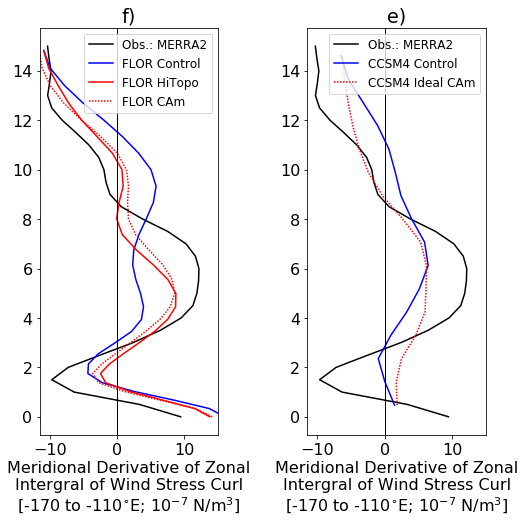

In [22]:
fig = plt.figure(figsize=(8,7.5))
plt.rcParams.update({'font.size': 16})
fig.subplots_adjust(wspace=0.5, hspace = 0.38)

y1 = 0.0
y2 = 15.0
deriv = {}
deriv['obs'] = curl['obs'].sel(LAT=slice(y1,y2)).sel(LON=slice(-170,-110)).integrate('LON').differentiate('LAT')
deriv['ctrl'] = curl['ctrl'].sel(LAT=slice(y1,y2)).sel(LON=slice(-170,-110)).integrate('LON').differentiate('LAT')
deriv['hitopo'] = curl['hitopo'].sel(LAT=slice(y1,y2)).sel(LON=slice(-170,-110)).integrate('LON').differentiate('LAT')
deriv['cam'] = curl['cam'].sel(LAT=slice(y1,y2)).sel(LON=slice(-170,-110)).integrate('LON').differentiate('LAT')
deriv['cesm_ctrl'] = curl['cesm_ctrl'].sel(LAT=slice(y1,y2)).sel(LON=slice(-170+360,-110+360)).integrate('LON').differentiate('LAT')
deriv['cesm_cam'] = curl['cesm_cam'].sel(LAT=slice(y1,y2)).sel(LON=slice(-170+360,-110+360)).integrate('LON').differentiate('LAT')

lats_o = deriv['obs'].LAT
lats_m = deriv['ctrl'].LAT
lats_mc = deriv['cesm_cam'].LAT

ax = plt.subplot(121)
plt.plot(deriv['obs']*1e7,lats_o,color='k',label='Obs.: MERRA2')
plt.plot(deriv['ctrl']*1e7,lats_m,color='b',label='FLOR Control')
plt.plot(deriv['hitopo']*1e7,lats_m,color='r',label='FLOR HiTopo')
plt.plot(deriv['cam']*1e7,lats_m,color='r',dashes=[1,1,1,1],label='FLOR CAm')
plt.xlabel('Meridional Derivative of Zonal\nIntergral of Wind Stress Curl\n[-170 to -110$^{\circ}$E; $10^{-7}$ N/m$^{3}$]')
#plt.ylabel('Latitude [$^{\circ}$N]')
plt.title('f)')
plt.legend(fontsize=12)
plt.xlim([-11.5,15])
plt.axvline(x=0,color='k',linewidth=1)

ax = plt.subplot(122)
plt.plot(deriv['obs']*1e7,lats_o,color='k',label='Obs.: MERRA2')
plt.plot(deriv['cesm_ctrl']*1e7,lats_mc,color='b',label='CCSM4 Control')
plt.plot(deriv['cesm_cam']*1e7,lats_mc,color='r',dashes=[1,1,1,1],label='CCSM4 Ideal CAm')
plt.xlabel('Meridional Derivative of Zonal\nIntergral of Wind Stress Curl\n[-170 to -110$^{\circ}$E; $10^{-7}$ N/m$^{3}$]')
#plt.ylabel('Latitude [$^{\circ}$N]')
plt.title('e)')
plt.legend(fontsize=12)
plt.xlim([-11.5,15])
plt.axvline(x=0,color='k',linewidth=1)

plt.savefig('windstresscurlintderiv.pdf')